In [1]:
import numpy as np
import pandas as pd
import sys

In [2]:
sys.path.append("../main")

from utils import read_data, process_time, merge_data

In [3]:
infos, items, orders = read_data("../main/datasets/")
process_time(orders)

In [4]:
display(orders)

,time,transactID,itemID,order,salesPrice,days,days_backwards,week_backwards,group_backwards
0,2018-01-01 00:01:56,2278968,450,1,17.42,1,180,26,13
1,2018-01-01 00:01:56,2278968,83,1,5.19,1,180,26,13
2,2018-01-01 00:07:11,2255797,7851,2,20.47,1,180,26,13
3,2018-01-01 00:09:24,2278968,450,1,17.42,1,180,26,13
4,2018-01-01 00:09:24,2278968,83,1,5.19,1,180,26,13
...,...,...,...,...,...,...,...,...,...
2181950,2018-06-29 23:54:22,2040347,9217,1,23.50,180,1,1,1
2181951,2018-06-29 23:55:09,2260943,2175,1,11.60,180,1,1,1
2181952,2018-06-29 23:55:09,2260943,2061,1,1.03,180,1,1,1
2181953,2018-06-29 23:55:09,2260943,2195,1,18.73,180,1,1,1


In [5]:
#position in month of the day
orders['posM_day']  = orders.time.dt.day

### feature month position of the week

In [6]:
#getting first and last date of every week
weeks = orders.groupby(['week_backwards'], as_index=False).agg({'time':['min', 'max']})
weeks.columns = ['week_backwards','first_date_w','last_date_w']

#ok, this is pretty ugly way to get the midle day of the week
# and its break for the first week, since we dont have the information of his 7 days
weeks['median'] = weeks['first_date_w'] + pd.DateOffset(days=3)

#first day of the week
#aka position in month of the first day of the week
weeks['posM_f_week'] = weeks['first_date_w'].map( lambda x : x.day)

#last day of the week
weeks['posM_l_week'] = weeks['last_date_w'].map( lambda x : x.day)

#midle day of the week
weeks['posM_m_week'] = weeks['median'].map( lambda x : x.day)


#left join with orders
weeks = weeks[['week_backwards','posM_f_week','posM_m_week','posM_l_week']]
orders = pd.merge(orders, weeks,on='week_backwards',how='left')

### feature month position of the group

In [7]:
#getting first and last date of every group
groups = orders.groupby(['group_backwards'], as_index=False).agg({'time':['min', 'max']})
groups.columns = ['group_backwards','first_date_g','last_date_g']

#ok, again a pretty ugly way to get the midle day of the group
groups['median'] = groups['first_date_g'] + pd.DateOffset(days=7)

#aka position in the month of the first day of the group
groups['posM_f_group'] = groups['first_date_g'].map( lambda x : x.day)

#last day of the group
groups['posM_l_group'] = groups['last_date_g'].map( lambda x : x.day)

#midle day of the group
groups['posM_m_group'] = groups['median'].map( lambda x : x.day)


#left join with orders
groups = groups[['group_backwards','posM_f_group','posM_m_group','posM_l_group']]
orders = pd.merge(orders, groups, on='group_backwards', how='left')

In [8]:
display(orders)

,time,transactID,itemID,order,salesPrice,days,days_backwards,week_backwards,group_backwards,posM_day,posM_f_week,posM_l_week,posM_m_week,posM_f_group,posM_l_group,posM_m_group
0,2018-01-01 00:01:56,2278968,450,1,17.42,1,180,26,13,1,1,5,4,1,12,8
1,2018-01-01 00:01:56,2278968,83,1,5.19,1,180,26,13,1,1,5,4,1,12,8
2,2018-01-01 00:07:11,2255797,7851,2,20.47,1,180,26,13,1,1,5,4,1,12,8
3,2018-01-01 00:09:24,2278968,450,1,17.42,1,180,26,13,1,1,5,4,1,12,8
4,2018-01-01 00:09:24,2278968,83,1,5.19,1,180,26,13,1,1,5,4,1,12,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181950,2018-06-29 23:54:22,2040347,9217,1,23.50,180,1,1,1,29,23,29,26,16,29,23
2181951,2018-06-29 23:55:09,2260943,2175,1,11.60,180,1,1,1,29,23,29,26,16,29,23
2181952,2018-06-29 23:55:09,2260943,2061,1,1.03,180,1,1,1,29,23,29,26,16,29,23
2181953,2018-06-29 23:55:09,2260943,2195,1,18.73,180,1,1,1,29,23,29,26,16,29,23


# visualing  total day salues in one month

In [17]:
def visu_sales(month):
    orders_m = orders[orders.time.dt.month == month]
    
    aux = orders_m.groupby(['days'], as_index=False).agg({'order':['sum', 'count']})
    
    #ploting total sales
    aux.plot(kind='bar',x='days',y=('order','sum'))
    
    #ploting number of rows
    aux.plot(kind='bar',x='days',y=('order','count'))
    

### visualizing i couldn't find a pattern

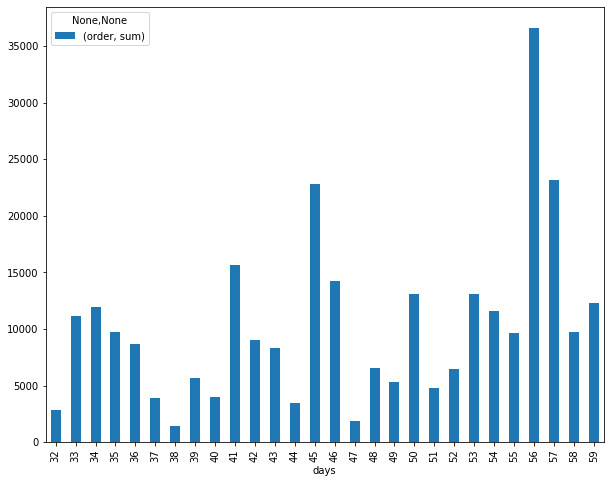

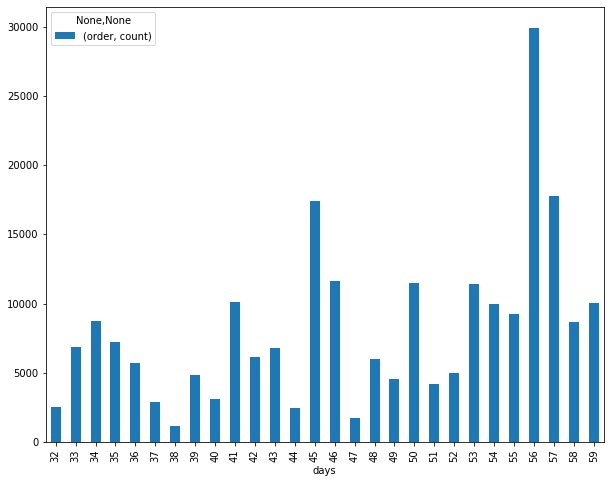

In [18]:
vizu_sales(2)

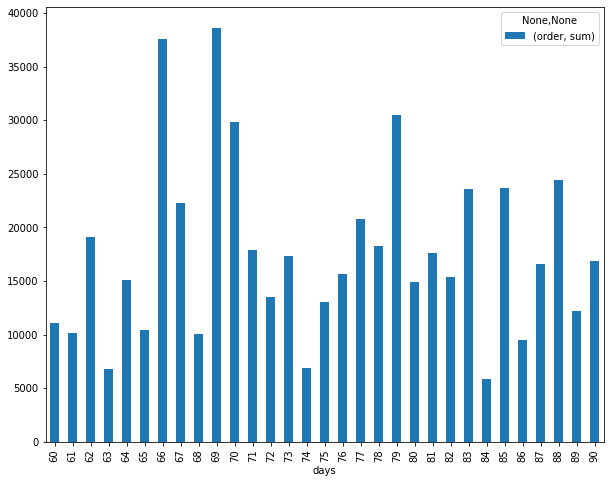

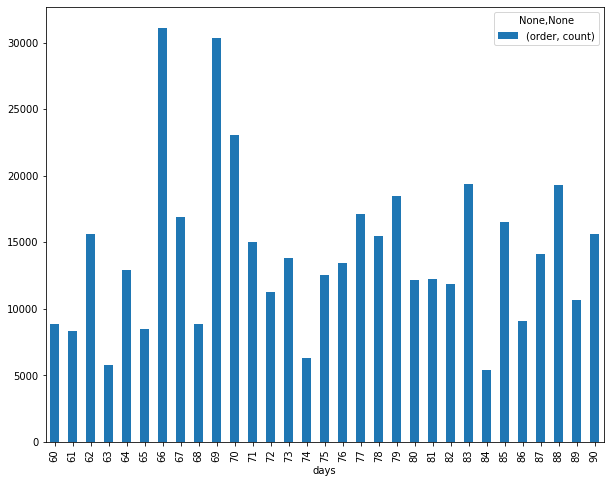

In [19]:
vizu_sales(3)

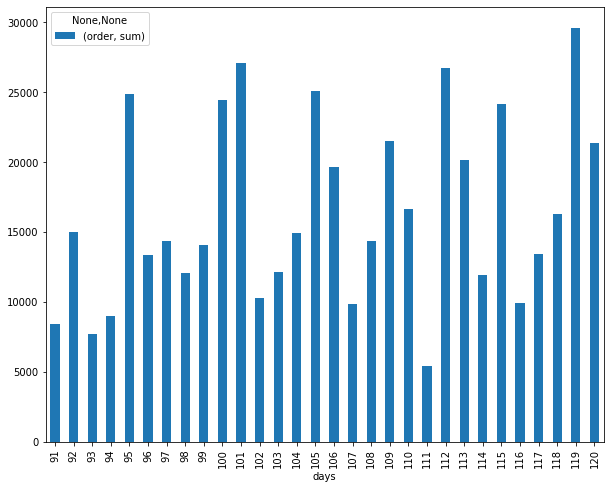

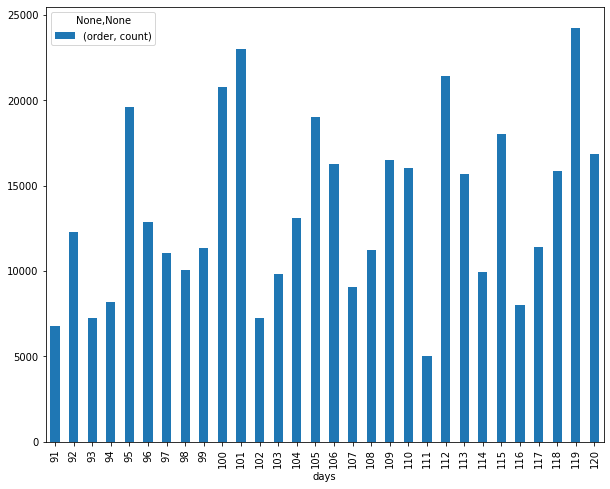

In [20]:
vizu_sales(4)

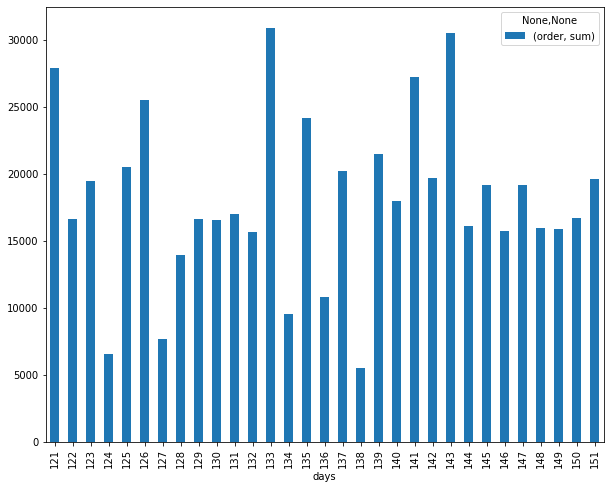

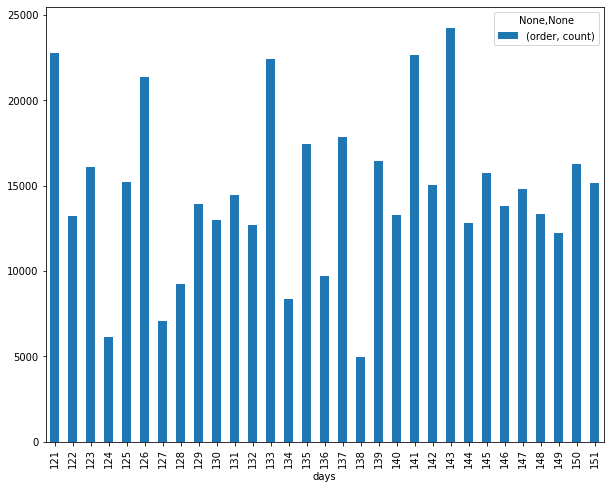

In [21]:
vizu_sales(5)

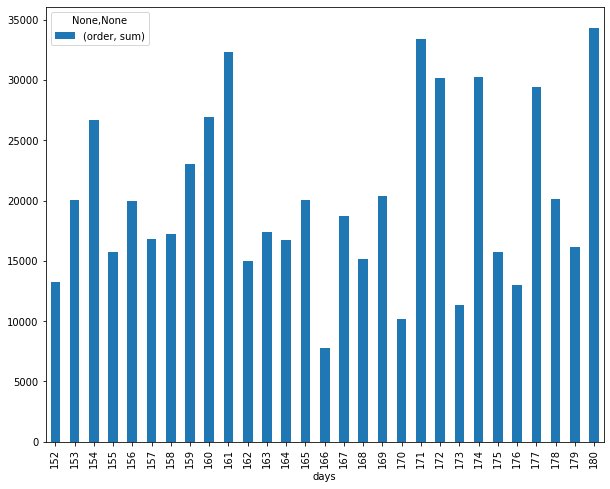

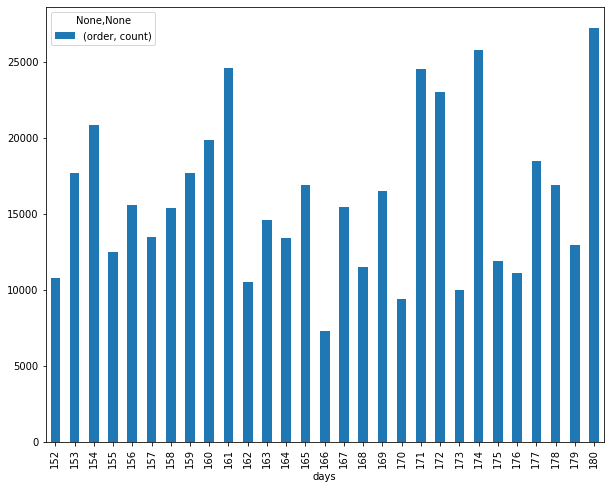

In [22]:
vizu_sales(6)